In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist
import matplotlib.pyplot as plt

### Création de la classe de Sampling

In [2]:
class Sampling(layers.Layer):
  """Generate a z vector from latent space based on z_mean and z_log_var"""
      
  def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


### On prend un espace latent de taille 2 pour pouvoir visualiser nos données en 2 dimensions.



In [3]:
latent_dim = 2

## Création de l'encoder

In [4]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

## On génère la moyenne et l'écart type qui va permettre à la couche de Sampling de créer z

In [5]:
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

In [6]:
z = Sampling()([z_mean, z_log_var])

### L'encoder prend en entrée nos données et fournit en sortie la moyenne, l'écart type et z

In [7]:
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

In [8]:
#encoder.summary()

## Création du decoder

In [9]:
inputs = keras.Input(shape=(latent_dim,))

In [10]:
inputs  = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)


In [11]:
outputs = layers.Conv2DTranspose(1,3,activation="sigmoid", padding="same")(x)
decoder = keras.Model(inputs, outputs, name="decoder")

In [12]:
#decoder.summary()

## Création de la classe VAE qui va nous permetre de calculer la perte, le gradient et lancer la propagation du gradient sur les poids

In [13]:
class VAE(keras.Model):
    
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):

        with tf.GradientTape() as tape:

            #---- Get encoder outputs
            #
            z_mean, z_log_var, z = self.encoder(data)

            #---- Get reconstruction from encoder
            #
            reconstruction = self.decoder(z)

            #---- Compute loss
            #     Reconstruction loss, KL loss and Total loss
            # 
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        # ---- Retrieve gradient from gradient_tape
        #      and run one step of gradient descent
        #      to optimize trainable weights
        #

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## On récupère les données MNIST

In [14]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255


11493376/11490434 [==============================] - 0s 0us/step


## On entraîne le VAE

In [15]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=20, batch_size=64)

Epoch 1/20
1094/1094 [==============================] - 41s 8ms/step - loss: 222.9215 - reconstruction_loss: 188.6172 - kl_loss: 4.2360
Epoch 2/20
1094/1094 [==============================] - 9s 8ms/step - loss: 165.7667 - reconstruction_loss: 156.6179 - kl_loss: 6.5038
Epoch 3/20
1094/1094 [==============================] - 9s 8ms/step - loss: 157.7475 - reconstruction_loss: 150.1997 - kl_loss: 6.8760
Epoch 4/20
1094/1094 [==============================] - 9s 8ms/step - loss: 153.9887 - reconstruction_loss: 146.8447 - kl_loss: 7.0224
Epoch 5/20
1094/1094 [==============================] - 9s 8ms/step - loss: 152.5006 - reconstruction_loss: 144.8299 - kl_loss: 7.1156
Epoch 6/20
1094/1094 [==============================] - 9s 8ms/step - loss: 150.8597 - reconstruction_loss: 143.2787 - kl_loss: 7.1431
Epoch 7/20
1094/1094 [==============================] - 9s 8ms/step - loss: 149.1416 - reconstruction_loss: 142.0030 - kl_loss: 7.1509
Epoch 8/20
1094/1094 [==============================] 

## Création de la fonction de visualisation

In [16]:
def plot_label_clusters(vae, data, labels):
  # affiche une représentation 2D de la clusterisation de la couche latente

  z_mean, _, _ = vae.encoder.predict(data)
  
  plt.figure(figsize=(12, 10))
  plt.scatter(z_mean[:,0], z_mean[:, 1], c=labels)
  plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.show()


In [17]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255


## Visualisation

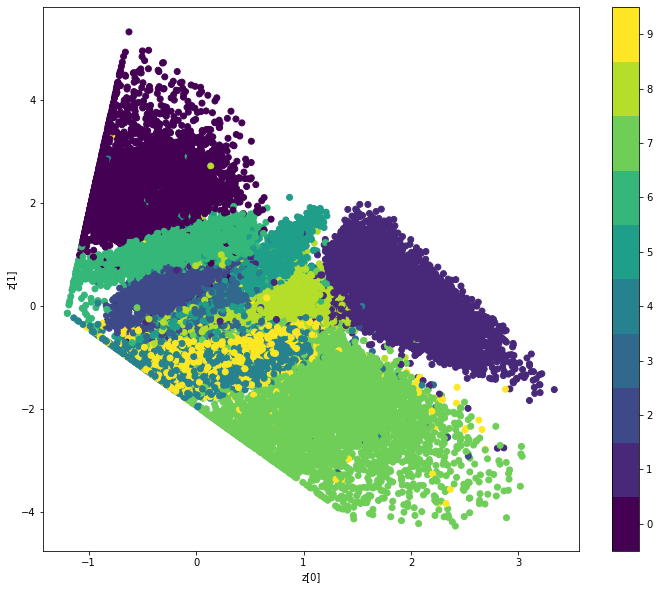

In [18]:
plot_label_clusters(vae, x_train, y_train)

## Fonction qui permet d'afficher  

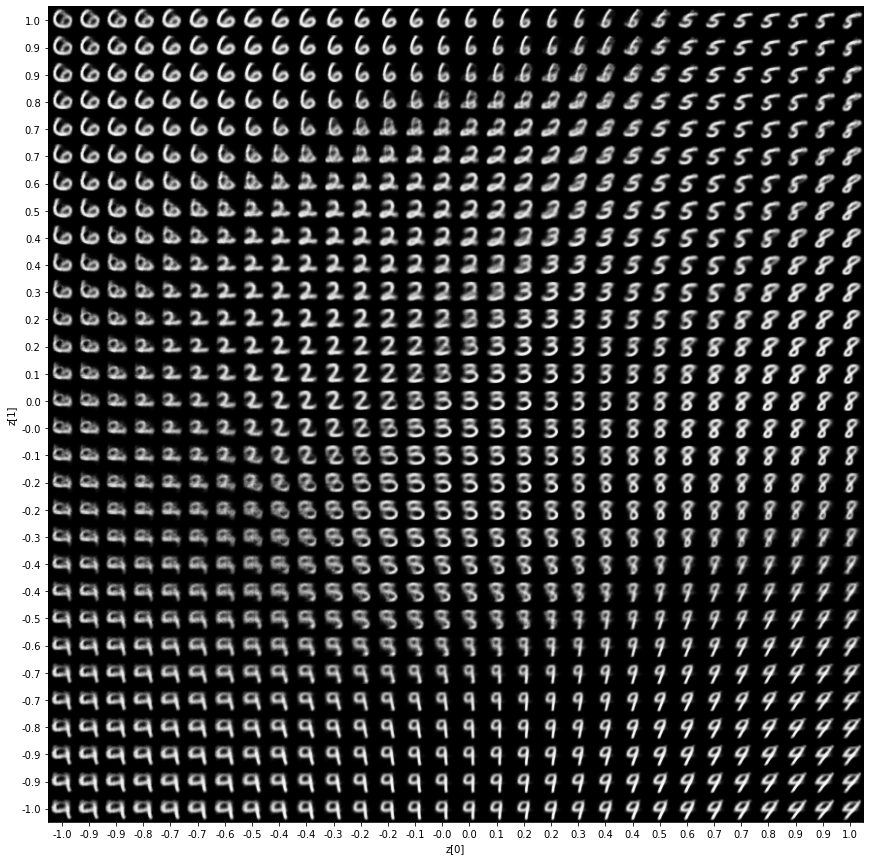

In [19]:
def plot_latent_space(vae, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)